# Stochastic Variable Inference

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch.distributions as dist
import pyro
from pyro import optim as optim
import pyro.distributions as dist
from torch.distributions import constraints
import pickle

In [2]:
data = pickle.load(open('xgb_models/data3.pkl', 'rb'))
X_train_target = data['X_train_target']
X_test_target = data['X_test_target']
X = data['X']

X_train = data['X_train']
X_test = data['X_test']
X_val = data['X_val']
X_all = data['X_all']

y_train = data['y_train']
y_test = data['y_test']
y_val = data['y_val']
y = data['y']

In [3]:
y_train = pd.DataFrame(y_train)
y_train

,Target
6482,0
2521,1
1691,0
2250,0
3880,1
...,...
5126,1
3453,1
1690,0
2675,1


# Model and Guide set-up

In [4]:
def model(x_data, y_data):
    
    gwd = pyro.sample('GWD', dist.Normal(0.,1.))
    elevation = pyro.sample('Elevation', dist.Normal(0.,1.))
    length = pyro.sample('L', dist.Normal(0.,1.))
    slope = pyro.sample('Slope', dist.Normal(0.,1.))
    pga = pyro.sample('PGA', dist.Normal(0.,1.))

    mean= gwd * x_data[:,0] + elevation * x_data[:,1] + \
        length * x_data[:,2] + slope * x_data[:,3] + \
        pga * x_data[:,4]
    
    #statement pyro.sample has obs paramter in order to condition the prediction on the given data
    with pyro.plate('data', x_data.shape[0]): #use_cuda=True
        pyro.sample('obs', dist.Bernoulli(1/(1+torch.exp(-mean))), obs=y_data)

In [8]:


def guide(x_data, y_data):

    weight_loc=pyro.param('weight_loc', torch.randn(5,device='cpu'))
    weight_scale=pyro.param('weight_scale', torch.ones(5,device='cpu'), constraint=constraints.positive)
    
    gwd = pyro.sample('GWD',dist.Normal(weight_loc[0], weight_scale[0]))
    elevation = pyro.sample('Elevation', dist.Normal(weight_loc[1], weight_scale[1]))
    length = pyro.sample('L', dist.Normal(weight_loc[2], weight_scale[2]))
    slope = pyro.sample('Slope', dist.Normal(weight_loc[3], weight_scale[3]))
    pga = pyro.sample('PGA', dist.Normal(weight_loc[4], weight_scale[4]))

    mean= gwd * x_data[:,0] + elevation * x_data[:,1] + \
        length * x_data[:,2] + slope * x_data[:,3] + \
        pga * x_data[:,4]    

    return 1/(1+torch.exp(-mean))



In [9]:
train_x = torch.tensor(X_train.to_numpy())
train_y = torch.tensor(y_train.to_numpy().flatten()).float()

In [10]:
from pyro.infer import SVI, Trace_ELBO
#we have used Adam optimizer which is a wrapper on Pytorch's Adam optimizer
#Addtionally we do not need to pass the learnable paramters explicitely like in Pytorch models. Here is happens in guide automatiaclly

#jusr like  non-Bayesian Linear Regression, each iteration of our training step will take gradient step with loss as MSE
# while in Bayesian we will use Evidence Lower Bound (ELBO) by contructing a Trace_Elbo object

svi=SVI(model, guide, optim.Adam({'lr':0.06}), loss=Trace_ELBO())

loss=[]
cntr=0
pyro.clear_param_store()
for i in range(3000):
    elbo=svi.step(train_x, train_y)
    
    if i % 10 == 0:
        print("Elbo loss: {}".format(elbo))
    cntr+=1
    loss.append(elbo)



Elbo loss: 5310.244506180286
Elbo loss: 4491.1538335084915
Elbo loss: 5055.191446661949
Elbo loss: 4621.679122149944
Elbo loss: 4683.813522398472
Elbo loss: 7868.037871837616
Elbo loss: 4211.542572915554
Elbo loss: 4520.768254935741
Elbo loss: 3936.0776200294495
Elbo loss: 4118.958224475384
Elbo loss: 3811.9143691062927
Elbo loss: 3877.014662563801
Elbo loss: 3942.131034076214
Elbo loss: 4529.531032085419
Elbo loss: 4374.346024811268
Elbo loss: 4490.364873468876
Elbo loss: 4032.9240455031395
Elbo loss: 6372.061260163784
Elbo loss: 4000.2920288443565
Elbo loss: 3829.544027209282
Elbo loss: 4360.116022348404
Elbo loss: 3878.8939397335052
Elbo loss: 3895.7306060791016
Elbo loss: 4105.2062739133835
Elbo loss: 3753.3979752659798
Elbo loss: 3776.627231478691
Elbo loss: 4031.1886326670647
Elbo loss: 3769.952966570854
Elbo loss: 3784.0134705901146
Elbo loss: 3780.0587821006775
Elbo loss: 3747.141509592533
Elbo loss: 3833.2516600489616
Elbo loss: 3808.1382152438164
Elbo loss: 3798.9241988658905

Text(0.5, 1.0, 'Loss with Iterations')

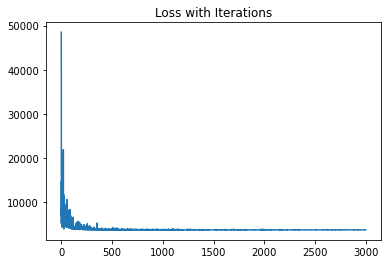

In [54]:
plt.plot(np.arange(cntr),loss)
plt.title("Loss with Iterations")

In [55]:
from pyro.infer import Predictive
def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats

predictive = Predictive(model, guide=guide, num_samples=800)
samples = predictive(train_x, train_y)
pred_summary = summary(samples)



In [56]:
for k in ['GWD', 'Elevation', 'L', 'Slope', 'PGA']:
    for p in pred_summary[k].keys():
        pred_summary[k][p]=pred_summary[k][p].item()
        



In [57]:
summary=pd.DataFrame(pred_summary)
summary.drop('obs',axis=1,inplace=True)
summary

,GWD,Elevation,L,Slope,PGA
mean,-0.390886,0.048609,-0.663129,0.037956,2.062912
std,0.015533,0.012623,0.027749,0.019110,0.070904
5%,-0.414836,0.028161,-0.707219,0.007895,1.949839
95%,-0.364889,0.070276,-0.617590,0.067781,2.178674


In [58]:
test_x = torch.tensor(X_test.to_numpy())
test_y = torch.tensor(y_test.to_numpy().flatten()).float()

In [63]:
preds = []
for i in range(len(test_y)):
    pred = guide(test_x,None).detach().cpu().numpy()
    #pred = sampled_reg_model(test_x,None)
    preds.append(pred)


In [64]:
preds=np.stack(preds).T
preds_mean=preds.mean(axis=1)
preds_med=preds.std(axis=1)

predc=pd.concat([pd.DataFrame(preds_mean),pd.DataFrame(preds_med)],axis=1)
predc.columns=['mean','std']
predc['mean']=np.where(predc['mean']>0.45,1,0)
predc

,mean,std
0,1,0.014508
1,0,0.026381
2,1,0.017251
3,1,0.016797
4,1,0.015863
...,...,...
1058,1,0.015011
1059,0,0.016010
1060,0,0.019710
1061,1,0.013765


In [68]:
predc['Actual'] = test_y 

In [69]:
predc

,mean,std,Actual
0,1,0.014508,0.0
1,0,0.026381,0.0
2,1,0.017251,0.0
3,1,0.016797,1.0
4,1,0.015863,0.0
...,...,...,...
1058,1,0.015011,1.0
1059,0,0.016010,0.0
1060,0,0.019710,1.0
1061,1,0.013765,0.0


In [81]:
print("Accuracy: %2.f%%" % (100* (1- np.sum(np.abs(predc['mean'] - predc['Actual']))/len(y_test))))


Accuracy: 59%
